# 1) Import

In [1]:
import tensorflow as tf
# check the version
tf.__version__

'2.8.0'

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D 
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing import image
from tensorflow.keras import initializers

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
%matplotlib inline

In [4]:
from __future__ import absolute_import, division, print_function
import cv2
import seaborn as sns
from PIL import Image

# 2) Load Data

In [5]:
# infected & uninfected
import os
print(os.listdir("/cell_images"))
infected = os.listdir("/cell_images/Parasitized/")
uninfected = os.listdir("/cell_images/Uninfected/")

['cell_images', 'Parasitized', 'Uninfected']


In [6]:
data = []
labels = []

for i in infected:
    try:
    
        image = cv2.imread("/cell_images/Parasitized/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((64 , 64))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        blur = cv2.blur(np.array(resize_img) ,(10,10))
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        data.append(np.array(blur))
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)
        
    except AttributeError:
        print('')
    
for u in uninfected:
    try:
        
        image = cv2.imread("/cell_images/Uninfected/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((64 , 64))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        labels.append(0)
        labels.append(0)
        labels.append(0)
        
    except AttributeError:
        print('')

In [7]:

cells = np.array(data)
labels = np.array(labels)


np.save('Cells' , cells)
np.save('Labels' , labels)

print('Cells : {} | labels : {}'.format(cells.shape , labels.shape))



Cells : (96453, 64, 64, 3) | labels : (96453,)


In [8]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]
#cells

In [9]:
# train_x & train_y to be used for training set // x & y to be used for cv and test 
X_train, X_test, y_train, y_test = train_test_split(cells, labels, 
                                            test_size = 0.2,
                                            random_state = 111)


In [10]:
print("train X shape: ", X_train.shape) # X_train: numpy array with shape: (num_samples_train, num_features)
print("train y shape: ", y_train.shape) # y_train: numpy array with shape: (num_samples_train,) 
print("test X shape: ", X_test.shape)   # X_test: numpy array with shape: (num_samples_test, num_features)
print("test y shape: ", y_test.shape)   # y_test: numpy array with shape: (num_samples_test,)

train X shape:  (77162, 64, 64, 3)
train y shape:  (77162,)
test X shape:  (19291, 64, 64, 3)
test y shape:  (19291,)


In [11]:
print("minimum train y value: ", min(y_train))
print("maximum train y value: ", max(y_train))

minimum train y value:  0
maximum train y value:  1


In [12]:
# Define the labels

labels = [
    'Uninfected', # 0
    'Infected',   # 1
]

In [13]:
# Rescale the image values so that they lie in between 0 and 1.

X_train = X_train / 255.
X_test = X_test / 255.

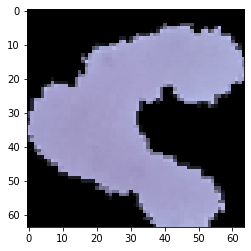

label: Infected


In [14]:
# Display one of the images

i = 5
img = X_train[i, : , :]
plt.imshow(img)
plt.show()
print(f"label: {labels[y_train[i]]}")

# 3) Best Model

In [15]:
# Build the Sequential convolutional neural network model

model = Sequential([
                    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', 
                           input_shape=(64,64,3), bias_initializer=initializers.RandomNormal(),
                           kernel_regularizer=tf.keras.regularizers.l2(0.005)), 
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dropout(0.2),
                    Dense(32, activation = 'relu'),
                    Dropout(0.2),
                    Dense(1, activation = 'sigmoid')

])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dropout (Dropout)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 32)                1843232   
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

# 4) Model Training With Validation Set

In [17]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
    loss = 'binary_crossentropy', #used binary_crossentropy because we have a binary output 
    metrics = ['accuracy'] 
)

In [18]:
#set early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5) 

In [19]:
# fit the model with validation set

history = model.fit(X_train, y_train, epochs = 16, batch_size = 256, verbose = 2, validation_split=0.2,
                    callbacks=[early_stopping]) 
# The 0.2 means that 20 percent of the training data will be held back for validation.

Epoch 1/16
242/242 - 85s - loss: 0.7635 - accuracy: 0.6712 - val_loss: 0.5053 - val_accuracy: 0.8412 - 85s/epoch - 350ms/step
Epoch 2/16
242/242 - 82s - loss: 0.3997 - accuracy: 0.8566 - val_loss: 0.2338 - val_accuracy: 0.9359 - 82s/epoch - 340ms/step
Epoch 3/16
242/242 - 81s - loss: 0.2498 - accuracy: 0.9206 - val_loss: 0.2074 - val_accuracy: 0.9333 - 81s/epoch - 335ms/step
Epoch 4/16
242/242 - 81s - loss: 0.2218 - accuracy: 0.9271 - val_loss: 0.2314 - val_accuracy: 0.9371 - 81s/epoch - 334ms/step
Epoch 5/16
242/242 - 81s - loss: 0.2047 - accuracy: 0.9279 - val_loss: 0.1904 - val_accuracy: 0.9428 - 81s/epoch - 336ms/step
Epoch 6/16
242/242 - 82s - loss: 0.1879 - accuracy: 0.9303 - val_loss: 0.1966 - val_accuracy: 0.9406 - 82s/epoch - 338ms/step
Epoch 7/16
242/242 - 82s - loss: 0.1782 - accuracy: 0.9306 - val_loss: 0.1881 - val_accuracy: 0.9409 - 82s/epoch - 337ms/step


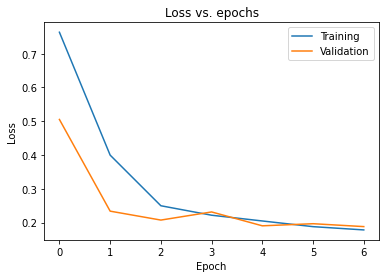

In [20]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# 5) Model Evaluate on Test

In [21]:
#used model with best results
test_loss, test_accuracy = model.evaluate(X_test, y_test)

603/603 [==============================] - 6s 10ms/step - loss: 0.1830 - accuracy: 0.9420


# 6) Save Weights

In [22]:
#save model weights after training
model.save_weights('cell_model_weights')

In [23]:
#save entire model
model.save('cell_model.h5')